<a href="https://colab.research.google.com/github/hamzafarooq/time_series/blob/master/Multiple_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import imageio
import os
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt


2.2.0


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Read Data


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')



Authenticated


In [ ]:
%%bigquery --project bold-sorter-281506 df2
SELECT EXTRACT(YEAR FROM date) AS year, EXTRACT(WEEK FROM date) AS week, sum(sale_dollars) as sales
FROM `bigquery-public-data.iowa_liquor_sales.sales`
where store_number  = '2633' and date < '2020-03-01'
group by 1,2
order by 1,2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df2 = pd.read_csv('/content/drive/My Drive/data/store_2633.csv')

In [ ]:
df2_ds = df2[['date','sale_dollars']]

In [ ]:
aggregated=df2_ds.groupby('date',as_index=False).sum()

In [ ]:
aggregated.head(5)

,date,sale_dollars
0,2015-01-05,99122.38
1,2015-01-07,5245.11
2,2015-01-08,94747.93
3,2015-01-12,73650.65
4,2015-01-14,1998.12


In [ ]:
import datetime
base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(len(aggregated))]

## Prophet Model

In [ ]:
from fbprophet import Prophet

In [ ]:
aggregated['y']=aggregated['sale_dollars']
#aggregated['ds']= pd.to_datetime(aggregated['date'])
aggregated['ds'] =sorted(date_list)
aggregated.drop(['sale_dollars','date'],axis=1,inplace=True)

In [ ]:
aggregated.head(5)

,y,ds
0,99122.38,2018-06-27 22:56:33.800928
1,5245.11,2018-06-28 22:56:33.800928
2,94747.93,2018-06-29 22:56:33.800928
3,73650.65,2018-06-30 22:56:33.800928
4,1998.12,2018-07-01 22:56:33.800928


In [ ]:
len(aggregated)

745

In [ ]:
train=aggregated[:710]
test=aggregated[710:]

In [ ]:
len(train)
len(test)

35

In [ ]:
m = Prophet(yearly_seasonality = True, weekly_seasonality=True,daily_seasonality=True)
m.fit(train)
future = m.make_future_dataframe(periods=35)
forecast = m.predict(future)

In [ ]:
m.plot_components(forecast)

In [ ]:
#forecast

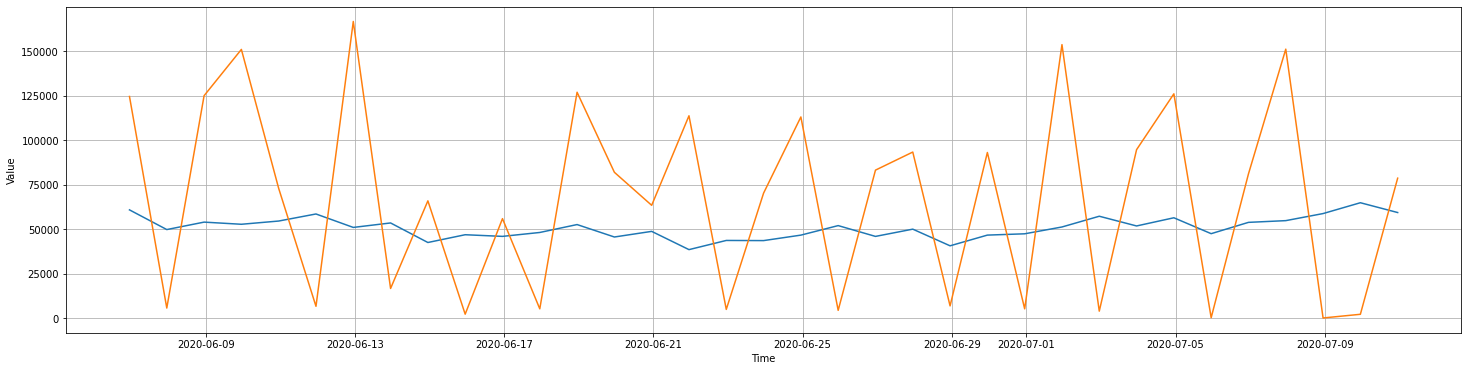

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(25, 6))
plot_series(forecast['ds'][710:], forecast['yhat'][710:])
#plot_series(train['ds'],train['y'])
plot_series(test['ds'],test['y'])

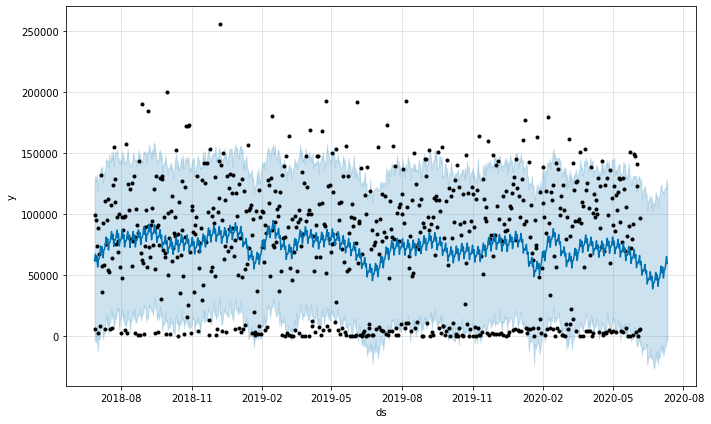

<Figure size 1800x432 with 0 Axes>

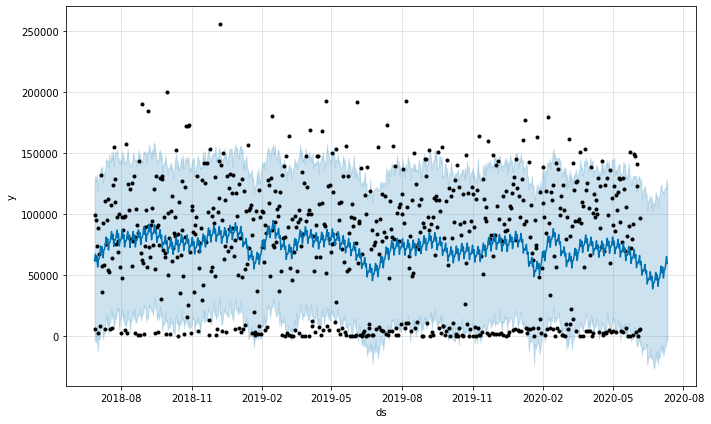

In [ ]:
plt.figure(figsize=(25, 6))
m.plot(forecast)


In [ ]:
tf.keras.metrics.mean_absolute_error(test['y'], forecast['yhat'][710:]).numpy()

50935.64499384005

##DNN 

Aggregating data by week

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')


Authenticated


In [ ]:
%%bigquery --project bold-sorter-281506 df2
SELECT EXTRACT(YEAR FROM date) AS year, EXTRACT(WEEK FROM date) AS week, sum(sale_dollars) as sales
FROM `bigquery-public-data.iowa_liquor_sales.sales`
where store_number  = '2633' and date < '2020-03-01'
group by 1,2
order by 1,2

In [ ]:
series=np.array(df2['sales'])

Min: 14005.000000, Max: 447836.720000


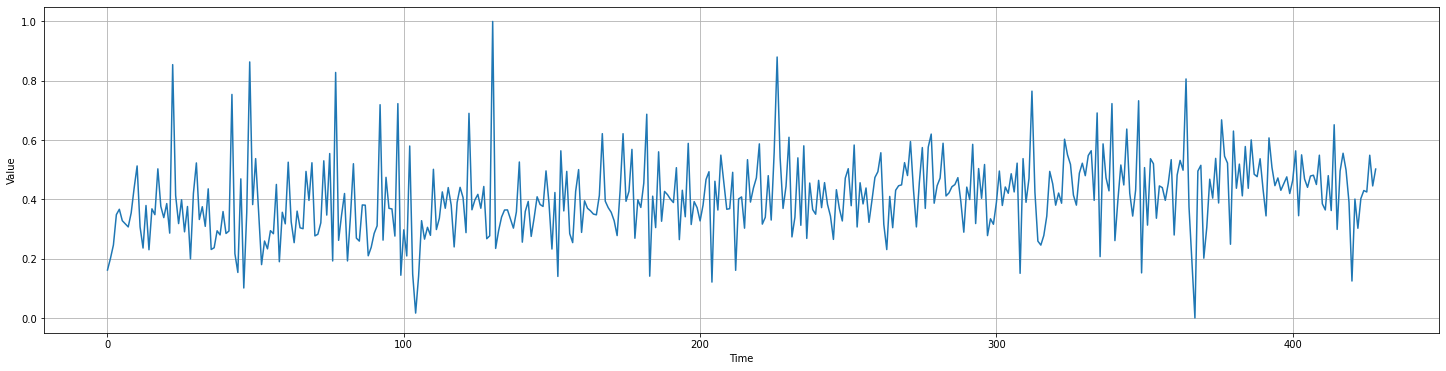

In [ ]:
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
series=np.array(df2['sales'])
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
values = series
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows
normalized = scaler.transform(values)
series=normalized.ravel()

import csv
time_step = []
temps = []


step=0
for row in range(len(df2)):
  time_step.append(step)
  step = step + 1

time = np.array(time_step)
plt.figure(figsize=(25, 6))
plot_series(time, series)

split_time = 370
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 5
batch_size = 100
shuffle_buffer_size = 200

In [ ]:
len(series)


429

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

The Long Short-Term Memory (LSTM) cell was proposed in 19977 by Sepp Hochreiter and Jürgen Schmidhuber and gradually improved over the years by several researchers, such as Alex Graves, Haşim Sak, and Wojciech Zaremba. If you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster, and it will detect long-term dependencies in the data. In Keras, you can simply use the LSTM layer instead of the SimpleRNN layer:

In [ ]:
model = tf.keras.models.Sequential([
                    
    tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.LSTM(20,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10))
])
train_set = windowed_dataset(x_train, window_size, batch_size=64, shuffle_buffer=shuffle_buffer_size)

def last_time_step_mse(Y_true, Y_pred):
    return tf.keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-05 * 10**(epoch / 200))


optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1776 - last_time_step_mse: 0.1772 - lr: 1.0000e-05
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1775 - last_time_step_mse: 0.1771 - lr: 1.0116e-05
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1774 - last_time_step_mse: 0.1769 - lr: 1.0233e-05
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1773 - last_time_step_mse: 0.1767 - lr: 1.0351e-05
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1771 - last_time_step_mse: 0.1765 - lr: 1.0471e-05
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1770 - last_time_step_mse: 0.1763 - lr: 1.0593e-05
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1769 - last_time_step_mse: 0.1761 - lr: 1.0715e-05
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1767 - last_time_step_mse: 0.1759 - lr: 1.0839e-05
Epoch 9/

(1e-05, 0.0001, 0.0, 0.9)

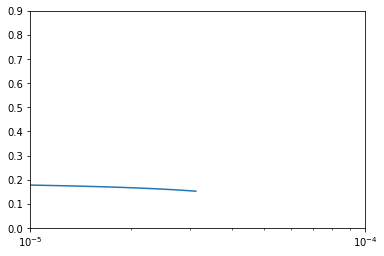

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-4, 0, 0.9])


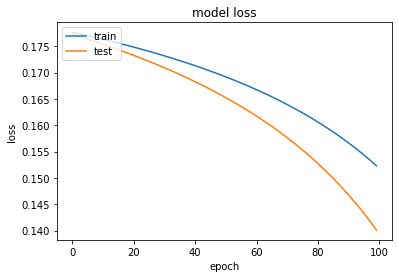

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['last_time_step_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Conv1D



In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1779 - last_time_step_mse: 0.1784 - lr: 1.0000e-05
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1778 - last_time_step_mse: 0.1782 - lr: 1.0116e-05
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1777 - last_time_step_mse: 0.1781 - lr: 1.0233e-05
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1776 - last_time_step_mse: 0.1780 - lr: 1.0351e-05
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1775 - last_time_step_mse: 0.1778 - lr: 1.0471e-05
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1774 - last_time_step_mse: 0.1777 - lr: 1.0593e-05
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1772 - last_time_step_mse: 0.1776 - lr: 1.0715e-05
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1771 - last_time_step_mse: 0.1775 - lr: 1.0839e-05
Epoch 

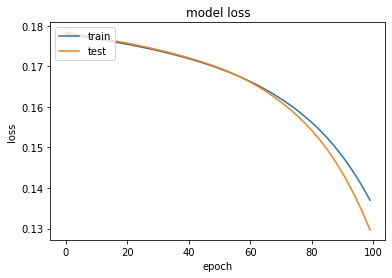

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['last_time_step_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## USING 1D CONVOLUTIONAL LAYERS TO PROCESS SEQUENCES



In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    tf.keras.layers.GRU(200, return_sequences=True),
    tf.keras.layers.GRU(200, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1778 - last_time_step_mse: 0.1783 - lr: 1.0000e-05
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1773 - last_time_step_mse: 0.1778 - lr: 1.0116e-05
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1768 - last_time_step_mse: 0.1772 - lr: 1.0233e-05
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1763 - last_time_step_mse: 0.1767 - lr: 1.0351e-05
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1757 - last_time_step_mse: 0.1762 - lr: 1.0471e-05
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1752 - last_time_step_mse: 0.1757 - lr: 1.0593e-05
Epoch 7/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1747 - last_time_step_mse: 0.1751 - lr: 1.0715e-05
Epoch 8/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1741 - last_time_step_mse: 0.1746 - lr: 1.0839e-05


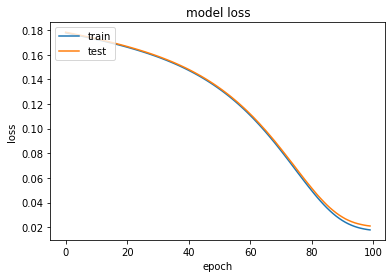

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['last_time_step_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## WAVENET
In a 2016 paper,13 Aaron van den Oord and other DeepMind researchers introduced an architecture called WaveNet. They stacked 1D convolutional layers, doubling the dilation rate (how spread apart each neuron’s inputs are) at every layer: the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on (see Figure 15-11). This way, the lower layers learn short-term patterns, while the higher layers learn long-term patterns. Thanks to the doubling dilation rate, the network can process extremely large sequences very efficiently.

![alt text](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1511.png). 

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(train_set,epochs=100)

Epoch 1/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1734 - last_time_step_mse: 0.1735
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1614 - last_time_step_mse: 0.1610
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1467 - last_time_step_mse: 0.1446
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1289 - last_time_step_mse: 0.1242
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1105 - last_time_step_mse: 0.1058
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0965 - last_time_step_mse: 0.0970
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0839 - last_time_step_mse: 0.0841
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0731 - last_time_step_mse: 0.0706
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0635 - last_time_step_mse: 0.0623
Epoch 10/100
6/6 [=================

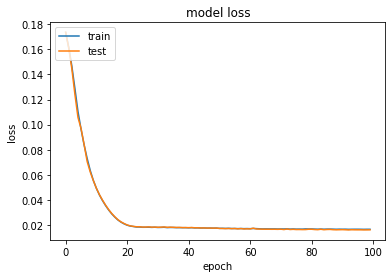

In [ ]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['last_time_step_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

0.08071925

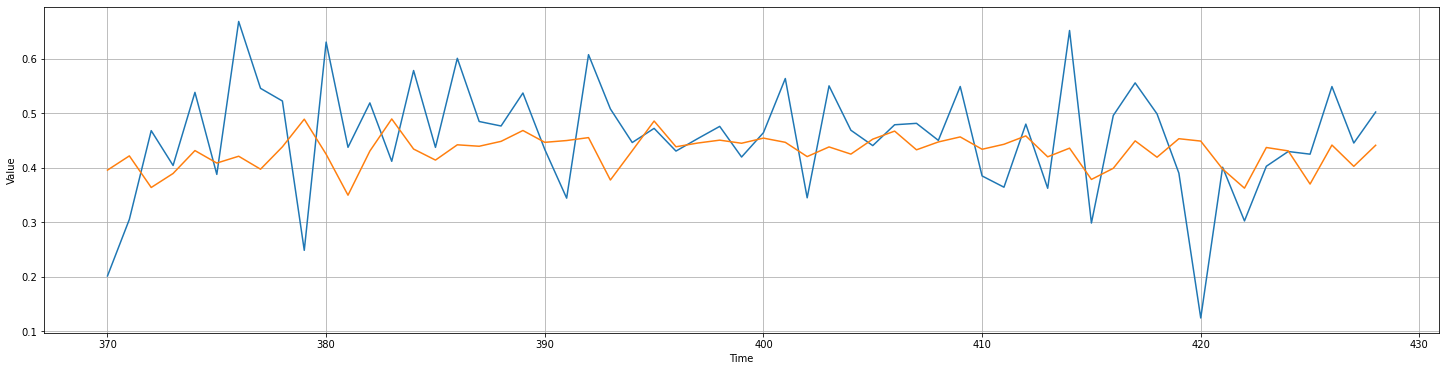

In [ ]:
lstm_forecast = model_forecast(model, series[..., np.newaxis], window_size)
lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]


plt.figure(figsize=(25, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast)
tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()



In [ ]:
def calc_smape(y_hat, y):
        return 100/len(y) * np.sum(2 * np.abs(y_hat - y) / (np.abs(y) + np.abs(y_hat)))

In [ ]:
from keras import backend as K
x_valid_scaled = scaler.inverse_transform(x_valid.reshape(-1,1))
lstm_forecast_scaled=scaler.inverse_transform(lstm_forecast.reshape(-1,1))
tf.keras.metrics.mean_absolute_error(x_valid_scaled.ravel(),lstm_forecast_scaled.ravel()).numpy()
#root_mean_squared_error(x_valid_scaled.ravel(),lstm_forecast_scaled.ravel())

calc_smape(x_valid_scaled.ravel(),lstm_forecast_scaled.ravel())

17.48504560521446

## LSTM + Conv1D +GRU



In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

window_size = 5
train_set = windowed_dataset(x_train, window_size, batch_size=64, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=20, kernel_size=4,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.GRU(200, return_sequences=True),
  tf.keras.layers.GRU(200, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x *400)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-05 * 10**(epoch / 200))
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss=["mse"],
              optimizer= optimizer,
              metrics=[last_time_step_mse])
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
6/6 [==============================] - 0s 53ms/step - loss: 0.3587 - last_time_step_mse: 0.2356 - lr: 1.0000e-05
Epoch 2/100
6/6 [==============================] - 0s 54ms/step - loss: 0.2183 - last_time_step_mse: 0.7047 - lr: 1.0116e-05
Epoch 3/100
6/6 [==============================] - 0s 55ms/step - loss: 0.0844 - last_time_step_mse: 0.1757 - lr: 1.0233e-05
Epoch 4/100
6/6 [==============================] - 0s 54ms/step - loss: 0.0878 - last_time_step_mse: 0.0271 - lr: 1.0351e-05
Epoch 5/100
6/6 [==============================] - 0s 53ms/step - loss: 0.0385 - last_time_step_mse: 0.0607 - lr: 1.0471e-05
Epoch 6/100
6/6 [==============================] - 0s 55ms/step - loss: 0.0437 - last_time_step_mse: 0.0913 - lr: 1.0593e-05
Epoch 7/100
6/6 [==============================] - 0s 54ms/step - loss: 0.0323 - last_time_step_mse: 0.0323 - lr: 1.0715e-05
Epoch 8/100
6/6 [==============================] - 0s 50ms/step - loss: 0.0278 - last_time_step_mse: 0.0272 - lr: 1.0839e-05


(1e-05, 0.0001, 0.0, 0.3)

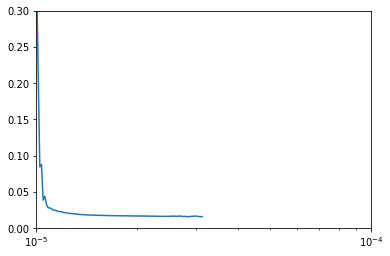

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-4, 0, 0.3])



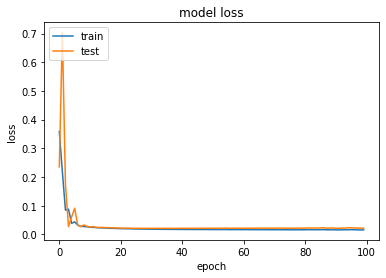

In [ ]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['last_time_step_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
lstm_forecast = model_forecast(model, series[..., np.newaxis], window_size)
lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]



In [ ]:
#model.weights

0.089462586

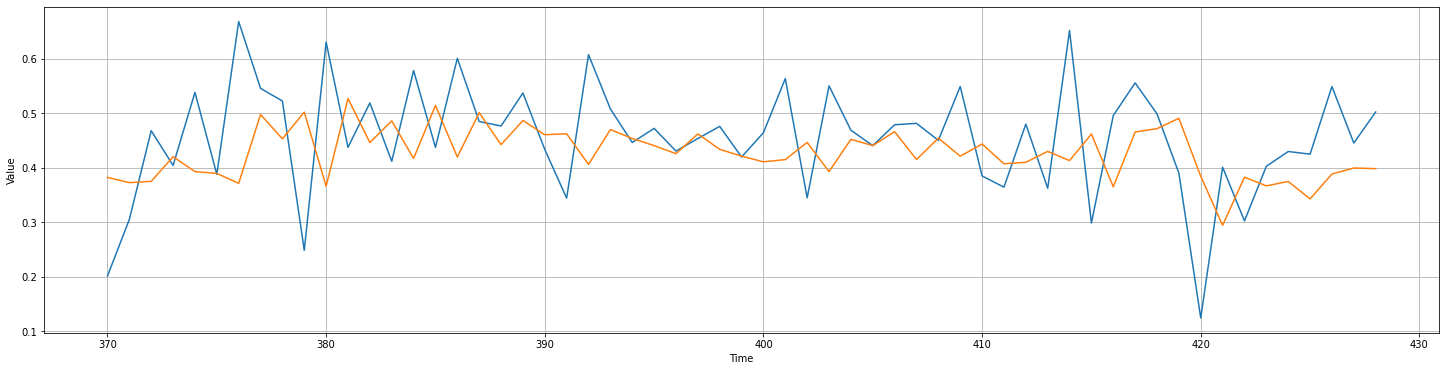

In [ ]:

plt.figure(figsize=(25, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast)
tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()


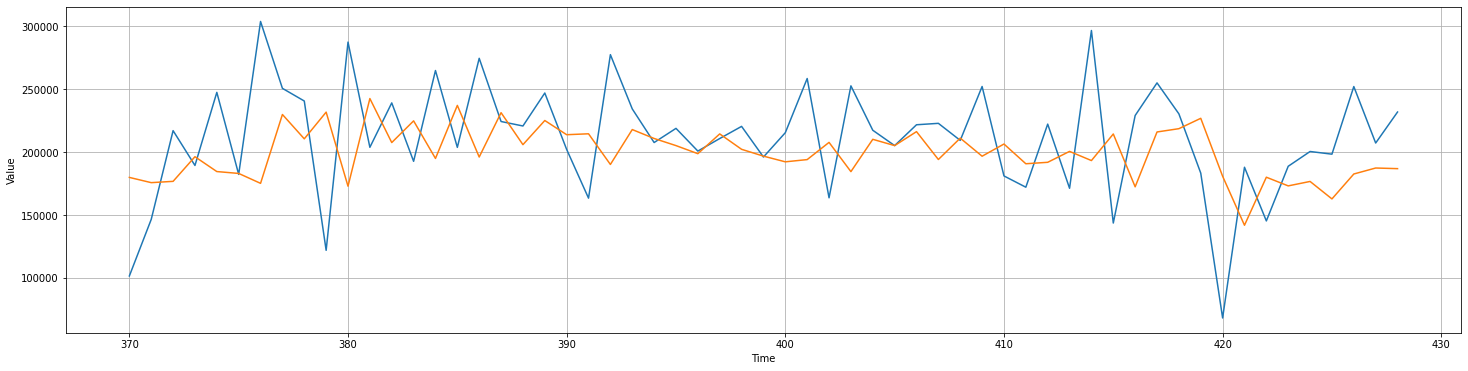

In [ ]:
plt.figure(figsize=(25, 6))

plot_series(time_valid, scaler.inverse_transform(x_valid.reshape(len(x_valid),1)))
plot_series(time_valid, scaler.inverse_transform(np.reshape(lstm_forecast,(len(lstm_forecast),1))))
#tf.keras.metrics.mean_absolute_error(scaler.inverse_transform(x_valid.reshape(len(x_valid),1), scaler.inverse_transform(np.reshape(lstm_forecast,(145,1))))).numpy()

In [ ]:
scaler.inverse_transform(x_valid.reshape(-1,1))

array([[215425.09],
       [258506.54],
       [163637.57],
       [252682.21],
       [217371.67],
       [205157.83],
       [221734.54],
       [222862.27],
       [209307.94],
       [252172.51],
       [181032.69],
       [172071.04],
       [222244.94],
       [171216.14],
       [296700.1 ],
       [143575.94],
       [229095.81],
       [255034.44],
       [230404.26],
       [183265.76],
       [ 68070.67],
       [187941.  ],
       [145257.42],
       [188717.97],
       [200464.65],
       [198345.94],
       [252119.79],
       [207201.61],
       [231870.53]])

In [ ]:
x_valid_scaled = scaler.inverse_transform(x_valid.reshape(-1,1))
lstm_forecast_scaled=scaler.inverse_transform(lstm_forecast.reshape(-1,1))
tf.keras.metrics.mean_absolute_error(x_valid_scaled.ravel(),lstm_forecast_scaled.ravel()).numpy()


38811.707

In [ ]:
calc_smape(x_valid_scaled.ravel(),lstm_forecast_scaled.ravel())

19.473185180744796

<Figure size 432x288 with 0 Axes>

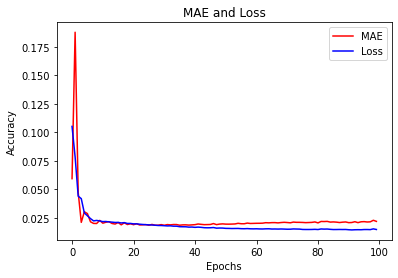

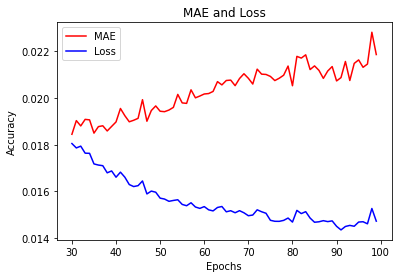

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['last_time_step_mse']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[30:]
mae_zoom = mae[30:]
loss_zoom = loss[30:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## Rnn + Conv1D

In [ ]:
def split_in_batches(data, n_steps):
   return data.reshape(-1)[:(data.size // n_steps * n_steps)].reshape(-1,n_steps,1)
n_steps=5
series2 = split_in_batches(series,n_steps)

In [ ]:
series2.shape

(85, 5, 1)

In [ ]:
import keras
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
np.random.seed(42)
tf.random.set_seed(42)


n_steps = 5
#series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series2[:60, :n_steps], series2[:60, -1]
X_valid, y_valid = series2[60:75, :n_steps], series2[60:75, -1]
X_test, y_test = series2[75:, :n_steps], series2[75:, -1]




In [ ]:
X_train.shape, y_train.shape

((60, 5, 1), (60, 1))

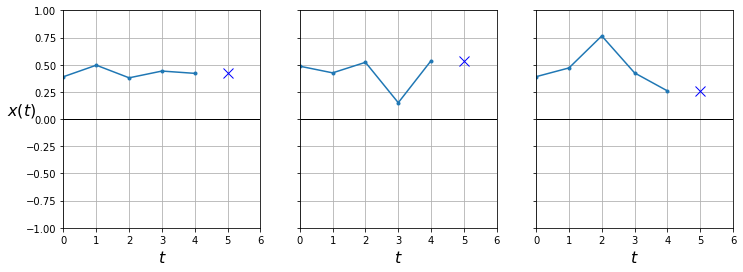

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))


#save_fig("time_series_plot")
plt.show()

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 60 samples, validate on 15 samples
Epoch 1/20
60/60 [==============================] - 0s 8ms/step - loss: 0.2337 - val_loss: 0.0950
Epoch 2/20
60/60 [==============================] - 0s 469us/step - loss: 0.1151 - val_loss: 0.0148
Epoch 3/20
60/60 [==============================] - 0s 466us/step - loss: 0.0244 - val_loss: 0.0983
Epoch 4/20
60/60 [==============================] - 0s 544us/step - loss: 0.0652 - val_loss: 0.0377
Epoch 5/20
60/60 [==============================] - 0s 460us/step - loss: 0.0165 - val_loss: 0.0124
Epoch 6/20
60/60 [==============================] - 0s 441us/step - loss: 0.0189 - val_loss: 0.0205
Epoch 7/20
60/60 [==============================] - 0s 475us/step - loss: 0.0333 - val_loss: 0.0208
Epoch 8/20
60/60 [==============================] - 0s 469us/step - loss: 0.0296 - val_loss: 0.0138
Epoch 9/20
60/60 [==============================] - 0s 475us/step - loss: 0.0151 - val_loss: 0.0131
Epoch 10/20
60/60 [==============================] - 0s 45

In [ ]:
model.evaluate(X_valid, y_valid)

15/15 [==============================] - 0s 526us/step


0.012837816961109638

In [ ]:
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

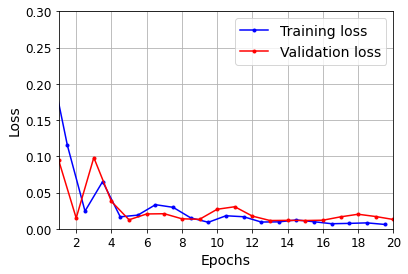

In [ ]:

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.3])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

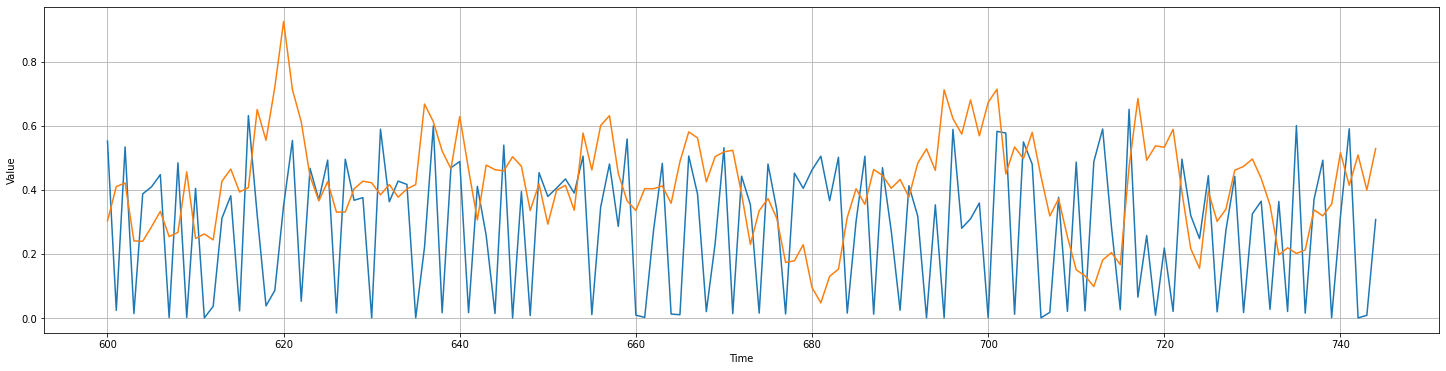

In [ ]:
plt.figure(figsize=(25, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
x_valid_scaled = scaler.inverse_transform(x_valid.reshape(-1,1))
rnn_forecast_scaled=scaler.inverse_transform(rnn_forecast.reshape(-1,1))
tf.keras.metrics.mean_absolute_error(x_valid_scaled.ravel(),rnn_forecast_scaled.ravel()).numpy()

60417.926